In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 3: Visualizing Classification Regions

The moons dataset is a simple built-in dataset from the [scikit-learn library](https://scikit-learn.org/stable/)

Text(0.5, 1.0, 'Moons dataset')

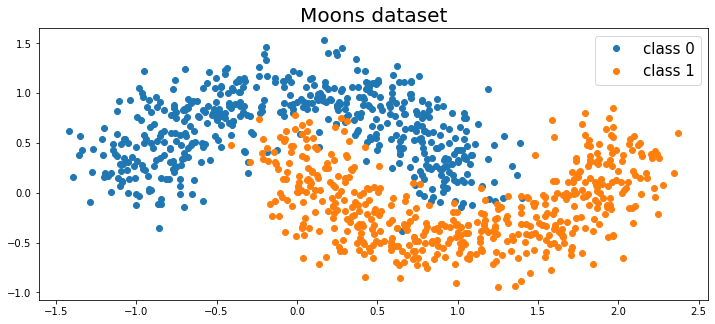

In [2]:
# run this cell to generate and visualize the dataset
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=1000,noise=0.2)

plt.figure(figsize=(12,5))
plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
plt.legend(fontsize=15)
plt.title('Moons dataset', fontsize=20)

## Part 1

Fit a **logistic regression** model to the data.

In [3]:
# sigmoid funcion
def sigmoid(t):
    return 1/(1+np.exp(-t))

# logistic regression cost function
def logregression_cost(y,X,theta):
    m = len(y)
    p = sigmoid(X.dot(theta))
    return (-1/m)*np.sum(y*np.log(p) + (1-y)*np.log(1-p))

# Logistic regression with Gradient Descent
def logregression_GD(X,y,learning_rate, n_epochs, return_cost=False):
    
    m,n = X.shape
    theta = np.random.randn(n)
    
    # initialize cost vector (only if return_cost = True)
    if return_cost:
        cost = np.zeros(n_epochs)
    
    # gradient descent steps
    for epoch in range(n_epochs):
        gradient = (1/m)*X.T.dot(sigmoid(X.dot(theta))-y) # compute gradient
        theta = theta - learning_rate*gradient # Gradient Descent Step
        if return_cost:
            cost[epoch] = logregression_cost(y,X,theta) # compute the cost function
            
    results = {}
    results['theta'] = theta
    if return_cost:
        results['cost'] = cost
        
    return results

In [4]:
# gradient descent
results = logregression_GD(X,y, 
                           learning_rate=1,
                           n_epochs = 200,
                           return_cost = True
                          )

Text(0, 0.5, 'cost')

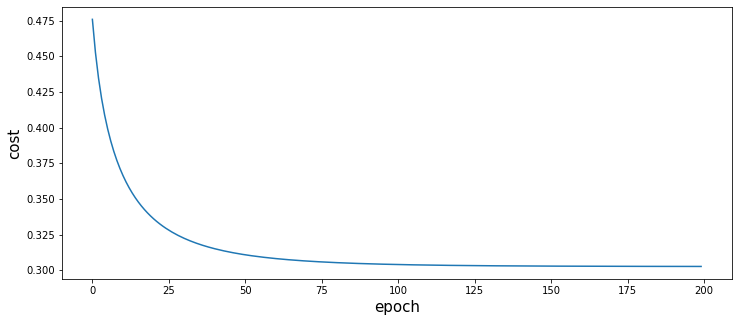

In [5]:
cost = results['cost']
plt.figure(figsize=(12,5))
plt.plot(cost)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('cost', fontsize=15)

In [6]:
theta = results['theta']

## Part 2

Your logistic regression model will split the feature space into regions called **classification regions**. 
All points in a classification region are assigned to the same class.
Run the following two cells to visualize the decision regions.
Notice that the boundary between regions is linear.

In [7]:
def plot_classification_regions(X, y, theta, degree=0, bias=False):
    from matplotlib.colors import ListedColormap
    from itertools import chain
    from itertools import combinations_with_replacement as comb_w_r
    
    # create a 100x100 meshgrid
    m_plot = 100
    x1 = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, m_plot)
    x2 = np.linspace(X[:,1].min()-0.5,X[:,1].max()+0.5, m_plot)
    X1, X2 = np.meshgrid(x1, x2) 
    X_plot = np.c_[X1.ravel(), X2.ravel()]
    
    
    
    # polynomial features
    if degree==0:
        X_plot_poly = X_plot
    else:
        n = 2
        # number of polynomial features
        combinations  = chain.from_iterable(comb_w_r(range(n), i) for i in range(1, degree+1))
        n_poly = sum(1 for comb in combinations)
        # add polynomial features
        combinations  = chain.from_iterable(comb_w_r(range(n), i) for i in range(1, degree+1))
        X_plot_poly = np.ones((m_plot**2,n_poly))
        for col_idx,combination in enumerate(combinations):  
            for idx in combination:
                X_plot_poly[:,col_idx]= X_plot_poly[:,col_idx]*X_plot[:,idx]
    # add bias            
    if bias:
        X_plot_poly = np.c_[np.ones(m_plot**2),X_plot_poly]

    # evaluate the log regression model  at each point of the mesh grid    
    y_plot = sigmoid(X_plot_poly.dot(theta))
        
    # class prediction    
    y_plot[y_plot>=0.5]=1
    y_plot[y_plot<0.5]=0
    y_plot = y_plot.reshape(X1.shape)

    custom_cmap = ListedColormap(['#9898ff','#fafab0'])
    # contour map
    colors = ['blue','red','green']
    plt.figure(figsize=(12,5))
    plt.contourf(X1, X2, y_plot, alpha=0.3, cmap=custom_cmap)
    
    
    plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
    plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
    plt.legend(fontsize=15)
    plt.title('Moons dataset', fontsize=20)


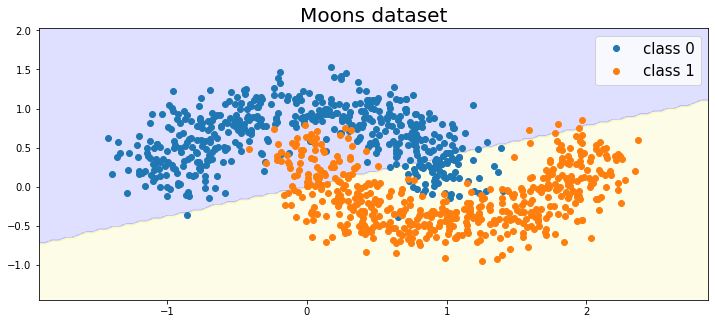

In [8]:
# run this cell to visualize the classification regions
plot_classification_regions(X, y, theta)

## Part 3

Add the polynomial features of degree 3 and the bias term to your logistic regression model.

In [18]:
degree = 3

In [14]:
from itertools import chain
from itertools import combinations_with_replacement as comb_w_r

In [17]:
m,n = X.shape

In [19]:
# number of polynomial features
combinations  = chain.from_iterable(comb_w_r(range(n), i) for i in range(1, degree+1))
n_poly = sum(1 for comb in combinations)

9

In [20]:
# add polynomial features
combinations  = chain.from_iterable(comb_w_r(range(n), i) for i in range(1, degree+1))
XP = np.ones((m,n_poly))
for col_idx,combination in enumerate(combinations):  
    for idx in combination:
        XP[:,col_idx]= XP[:,col_idx]*X[:,idx]

In [21]:
# add bias
XP = np.c_[np.ones(len(y)),XP]

In [22]:
XP.shape

(1000, 10)

In [23]:
# gradient descent
results = logregression_GD(XP,y, 
                           learning_rate=0.1,
                           n_epochs = 5000,
                           return_cost = True
                          )

Text(0, 0.5, 'cost')

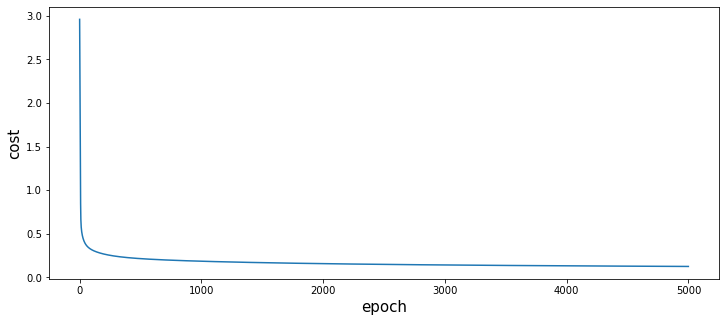

In [24]:
cost = results['cost']
plt.figure(figsize=(12,5))
plt.plot(cost)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('cost', fontsize=15)

In [25]:
theta = results['theta']

## Part 4

Run the following cell to visualize the new decision regions.

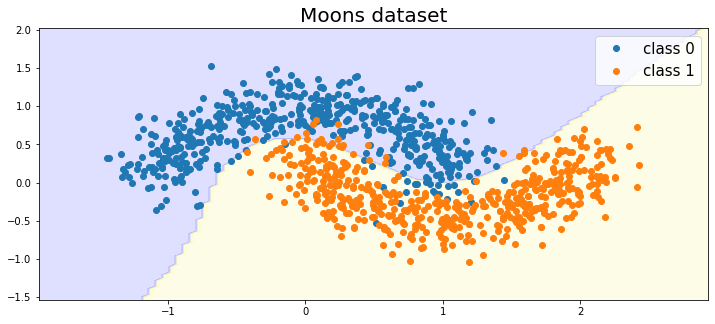

In [27]:
plot_classification_boundary(X, y, theta, degree=degree, bias=True)